# Segmentation of Brain MRI Scan
Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the project is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which will be evaluated for final segmentation accuracy.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

## Downloading the Data

In [ ]:
! wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip -qq -o brainage-data.zip
! wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip -qq -o brainage-testdata.zip


brainage-data.zip   100%[===================>] 446.94M  83.6MB/s    in 5.2s    
brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      


In [ ]:
from google.colab import drive
from pathlib import Path

gdrive_path = "/content/gdrive/MyDrive"
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path(gdrive_path)

Mounted at /content/gdrive


## Imports

In [ ]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()



%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

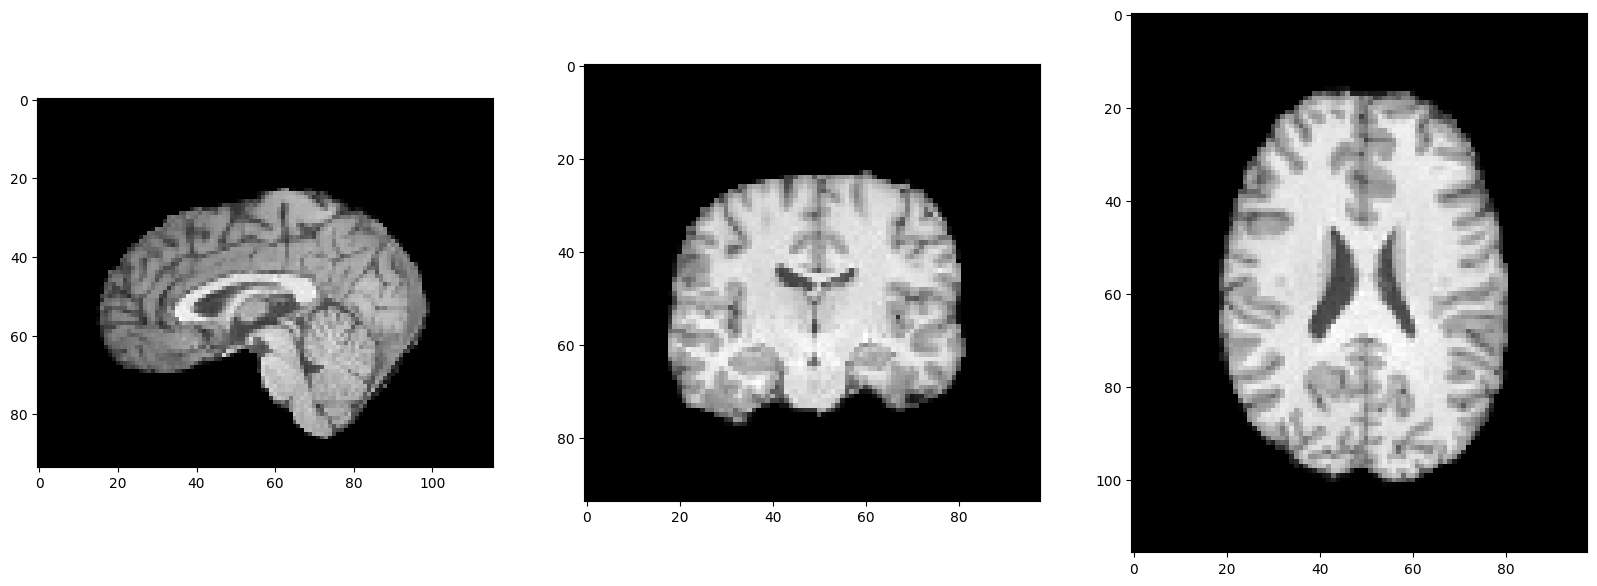

In [ ]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [ ]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:04<00:00, 151.37it/s]


In [ ]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 80548.03it/s]

522 train files
65 val files
65 test files


Visualization of one validations sample

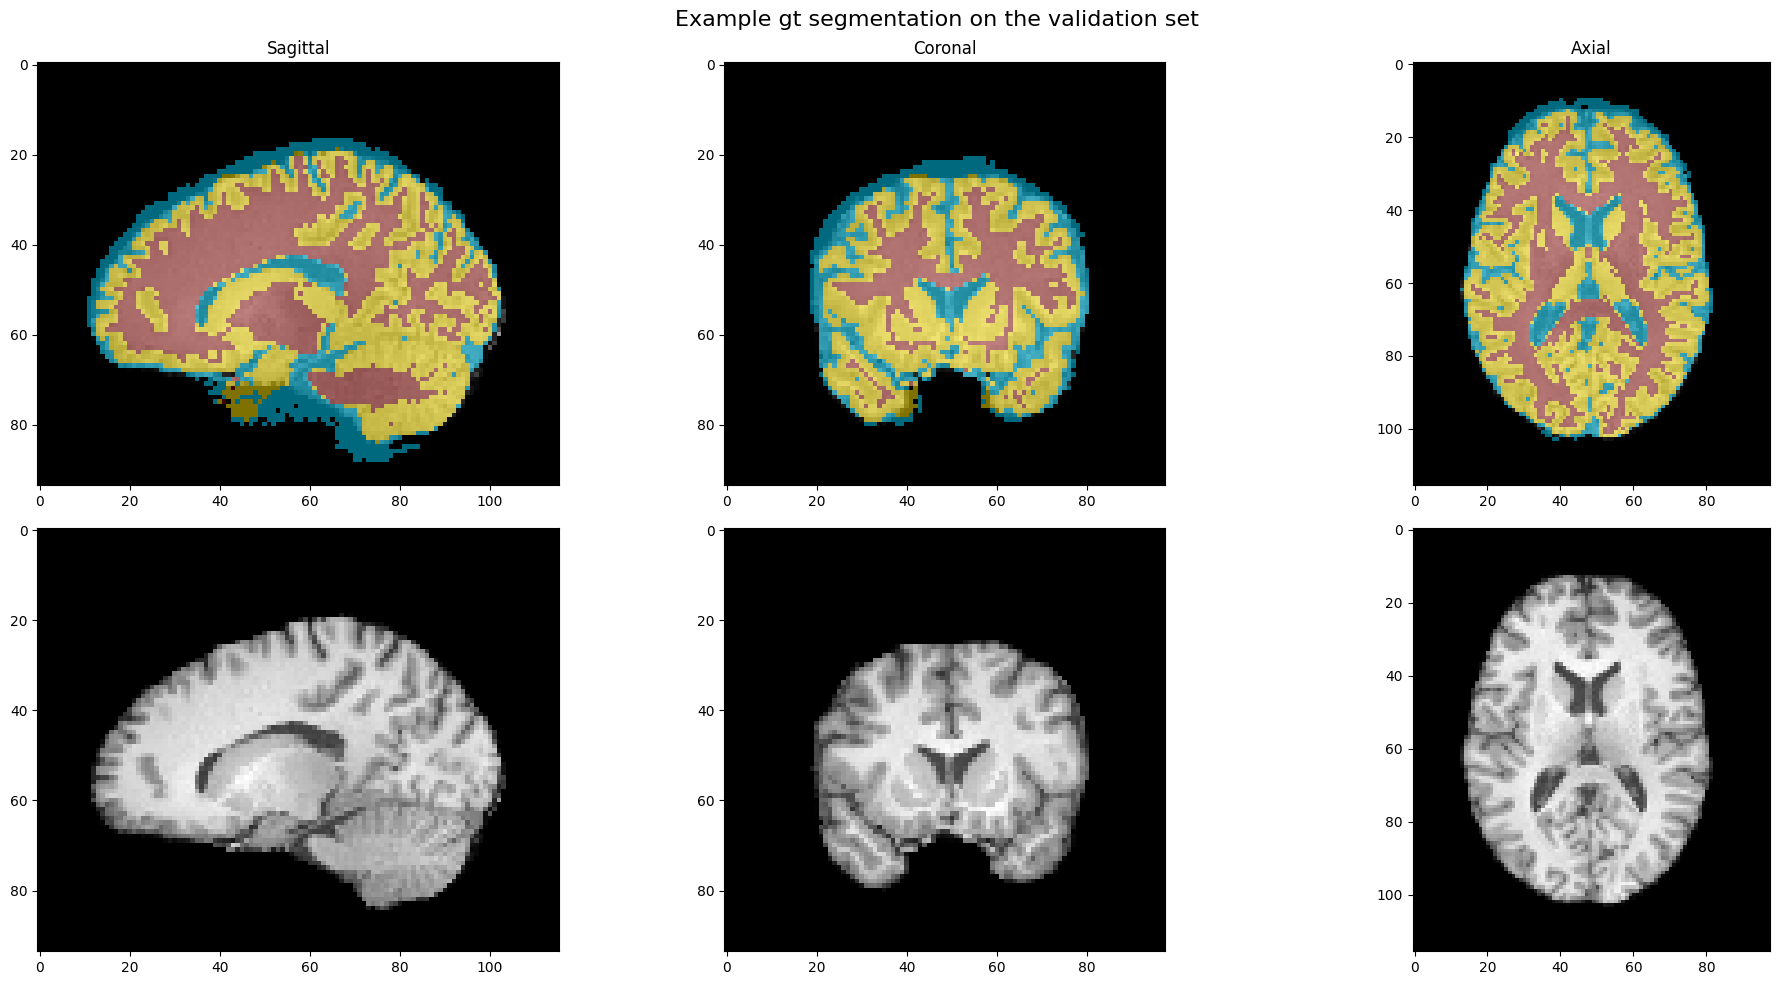

In [ ]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=42, title='Example gt segmentation on the validation set')

# Evaluation and Visualization Functions

**Q1a**. We first have to define how good our predicted segmentations are. Implement the evaluation functions below.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
""" Change seg datasets from list to tensor"""

segmentations_train = torch.tensor(np.array(segmentations_train), device = device)
segmentations_val = torch.tensor(np.array(segmentations_val), device = device)
segmentations_test  = torch.tensor(np.array(segmentations_test), device = device)

In [ ]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms.

def Dice(predictions, gt):
    """Calculate patient-wise mean and std of the DICE SCORE

    Parameters
    ----------
    predictions : int tensor in range (0, num_classes)
        shape: (Batch, Width, Depth, Height)
    gt : int tensor in range (0, num_classes)
        shape: (Batch, Width, Depth, Height)

    Returns
    -------
    mean : float tensor,
        shape (Batch)
    std : float tensor,
        shape (Batch)
    score_cls: float tensor,
        shape (num_classes, Batch)
    """
    mean, std = None, None

    # number of classes in ground truth
    classes = torch.unique(gt)
    # dice score for each class
    # list with shape (num_classes, Batch)
    dscs = torch.tensor([], device = device)

    for cls in classes:
        # boolean ndarray with shape (Batch, Width, Depth, Height)
        pre_cur_cls = predictions == cls
        gt_cur_cls = gt == cls

        # shape (Batch)
        overlap = torch.sum((pre_cur_cls & gt_cur_cls), dim= (1,2,3))

        # DSC = 2*|A and B| / (|A| + |B|)
        # shape (Batch)
        dsc = 2 * overlap / (torch.sum(pre_cur_cls, dim= (1,2,3)) + torch.sum(gt_cur_cls, dim= (1,2,3)))
        dscs = torch.cat((dscs, dsc.unsqueeze(0)))

    mean = torch.mean(dscs, dim=0)
    std = torch.std(dscs, dim=0)
    score_cls = dscs
    return mean, std, score_cls


def precision(predictions, gt):
    """Calculate patient-wise mean and std of the PRECISION

    Parameters
    ----------
    predictions : int tensor in range (0, num_classes)
        shape: (Batch, Width, Depth, Height)
    gt : int tensor in range (0, num_classes)
        shape: (Batch, Width, Depth, Height)

    Returns
    -------
    mean : float tensor,
        shape (Batch)
    std : float tensor,
        shape (Batch)
    score_cls: float tensor,
        shape (num_classes, Batch)
    """
    mean, std = None, None
    # number of classes in ground truth
    classes = torch.unique(gt)
    # precisions for each class
    # shape (num_classes, Batch)
    precisions = torch.tensor([], device = device)

    for cls in classes:
        # prediction of current class
        pre_cur = predictions == cls
        gt_cur = gt == cls

        # ture positive: pre = true, gt = true
        tp = torch.sum((pre_cur & gt_cur),  dim= (1,2,3))
        # false positive: pre = true, gt = false
        fp = torch.sum((pre_cur & ~gt_cur), dim= (1,2,3))

        # precision = TP / TP + FP
        precision = tp / (tp + fp)

        precisions = torch.cat((precisions, precision.unsqueeze(0)))

    mean = torch.mean(precisions, dim=0)
    std = torch.std(precisions, dim=0)
    score_cls = precisions
    return mean, std, score_cls


def recall(predictions, gt):
    """Calculate patient-wise mean and std of the RECALL

    Parameters
    ----------
    predictions : int tensor in range (0, num_classes)
        shape: (Batch, Width, Depth, Height)
    gt : int tensor in range (0, num_classes)
        shape: (Batch, Width, Depth, Height)

    Returns
    -------
    mean : float tensor,
        shape (Batch)
    std : float tensor,
        shape (Batch)
    score_cls: float tensor,
        shape (num_classes, Batch)
    """
    mean, std = None, None
    # number of classes in ground truth
    classes = torch.unique(gt)
    # precisions for each class
    recalls = torch.tensor([], device = device)

    for cls in classes:
        # prediction of current class
        pre_cur = predictions == cls
        gt_cur = gt == cls

        # ture positive: pre = true, gt = true
        tp = torch.sum((pre_cur & gt_cur), axis=(1,2,3))
        # false negative: pre = false, gt = true
        fn = torch.sum((~pre_cur & gt_cur), axis=(1,2,3))
        # recalls = TP / TP + FN
        recall = tp / (tp + fn)

        recalls = torch.cat((recalls, recall.unsqueeze(0)))

    mean = torch.mean(recalls, dim=0)
    std = torch.std(recalls, dim=0)
    score_cls = recalls
    return mean, std, score_cls




Metrics test

In [ ]:
""""TEST : metrics"""
print(segmentations_val.shape)
test_pred = torch.randint(0, 4, segmentations_val[0:5].shape).to(device)
test_gt = segmentations_val[0:5].to(device)
print("Dice:", Dice(test_pred, test_gt)[0:-1])
print("Precision:", precision(test_pred, test_gt)[0:-1])
print("Recall:", recall(test_pred, test_gt)[0:-1])

torch.Size([65, 98, 116, 94])
Dice: (tensor([0.1764, 0.1628, 0.1707, 0.1657, 0.1619], device='cuda:0'), tensor([0.1377, 0.1505, 0.1428, 0.1477, 0.1512], device='cuda:0'))
Precision: (tensor([0.2504, 0.2499, 0.2499, 0.2497, 0.2500], device='cuda:0'), tensor([0.3597, 0.3890, 0.3729, 0.3820, 0.3907], device='cuda:0'))
Recall: (tensor([0.2507, 0.2496, 0.2495, 0.2491, 0.2503], device='cuda:0'), tensor([0.0008, 0.0006, 0.0012, 0.0009, 0.0008], device='cuda:0'))


In [ ]:

def get_best_and_worst_ids(predictions):
    """Find ids of samples with best and worst Dice score

    Parameters
    ----------
    predictions : int tensor in range (0, num_classes)
        shape: (Batch, Width, Depth, Height)

    Returns
    -------
    best_ids: int
    best_performance: float
    worst_ids: int
    worst_performance: float
    """

    best_ids, worst_ids = -1, -1
    best_performance, worst_performance = None, None

    gt = segmentations_test

    dice_scores, _, _ = Dice(predictions, gt)

    best_ids = torch.argmax(dice_scores).item()
    best_performance = dice_scores[best_ids].item()
    worst_ids = torch.argmin(dice_scores).item()
    worst_performance = dice_scores[worst_ids].item()

    return {
        'best_id': best_ids,
        'best_performance': best_performance,
        'worst_id': worst_ids,
        'worst_performance': worst_performance
    }

def visualize_best_and_worst_samples(predictions, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions)

    best_id = return_dict['best_id']
    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id].cpu().numpy(), i=i_best,
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    worst_id = return_dict['worst_id']
    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id].cpu().numpy(), i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')



In [ ]:
"""TEST get_best_and_worst_ids"""
test_pred = torch.randint(0, 4, segmentations_val.shape).to(device)
print("Dice score: ", Dice(test_pred, segmentations_test)[0])
get_best_and_worst_ids(test_pred)


Dice score:  tensor([0.1659, 0.1605, 0.1790, 0.1729, 0.1842, 0.1576, 0.1534, 0.1695, 0.1587,
        0.1727, 0.1710, 0.1682, 0.1629, 0.1749, 0.1730, 0.1739, 0.1770, 0.1655,
        0.1656, 0.1647, 0.1663, 0.1605, 0.1729, 0.1644, 0.1699, 0.1738, 0.1679,
        0.1698, 0.1635, 0.1672, 0.1668, 0.1655, 0.1667, 0.1717, 0.1747, 0.1774,
        0.1629, 0.1669, 0.1660, 0.1758, 0.1672, 0.1817, 0.1672, 0.1762, 0.1697,
        0.1658, 0.1695, 0.1647, 0.1626, 0.1676, 0.1808, 0.1671, 0.1789, 0.1704,
        0.1654, 0.1645, 0.1686, 0.1756, 0.1633, 0.1756, 0.1751, 0.1687, 0.1719,
        0.1794, 0.1673], device='cuda:0')


{'best_id': 4,
 'best_performance': 0.18421505391597748,
 'worst_id': 6,
 'worst_performance': 0.15338322520256042}

In [ ]:



def get_results_dictionary(predictions_from_models):
    """Get a performance summary dict for each model

    Parameters
    ----------
    predictions_from_models : int tensor in range (0, num_classes)
        shape: (Models, Batch, Width, Depth, Height)

    Returns
    -------
    results_dict: Dict[str, Dict[str, Dict[str, str]]]
        just like sample_results, at least have one model, one class and its metrics
    """
    results_dict = {}

    # test dataset as our groundtruth
    gt = segmentations_test

    # number of models
    num_models = predictions_from_models.shape[0]


    # classes
    classes = ["background", "CSF", "GM", "WM"]

    for model_index , predictions in enumerate(predictions_from_models):

        # dice_cls/ precision_cls/ recall_cls: (num_classes, Batch)
        _, _, dice_cls = Dice(predictions, gt)
        _, _, precision_cls = precision(predictions, gt)
        _, _, recall_cls = recall(predictions, gt)

        # (num_classes, Batch) -> (num_classes)
        dice_cls_mean = torch.mean(dice_cls, dim=1)
        precision_cls_mean = torch.mean(precision_cls, dim=1)
        recall_cls_mean = torch.mean(recall_cls, dim=1)

        model_result_dict = {}
        for i in range(1, len(classes)):
            model_result_dict[classes[i]] = {
                "dice": str(dice_cls_mean[i].item()),
                "precision": str(precision_cls_mean[i].item()),
                "recall": str(recall_cls_mean[i].item()),
            }
        results_dict["model"+str(model_index)] = model_result_dict

    return results_dict


def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, str]]]) -> None:

    # Models, Metrics and classes
    models = list(results_dict.keys())
    classes = list(results_dict[models[0]].keys())
    metrics = list(results_dict[models[0]][classes[0]].keys())

    # Width of a bar
    gap = 0.3 # gap between different classes
    bar_width = (1- gap) /len(models)

    # Set position of bar on X axis
    positions = np.arange(len(classes))

    # create subplots for different metrics
    f, axs = plt.subplots(len(metrics), figsize=(10, 5 * len(metrics)))
    plt.ylim(0, 1)


    for index_metric, metric in enumerate(metrics):

        for i, (model, results) in enumerate(results_dict.items()):
            values = [float(results[cls][metric]) for cls in classes]
            bar_start_points = positions - ((len(results_dict.items())-1)* bar_width)/2
            axs[index_metric].bar(bar_start_points + i*bar_width, values, bar_width, label=model)

        # Adding xticks
        axs[index_metric].set_ylabel(metric)
        axs[index_metric].set_title(f'{metric} for each class')
        axs[index_metric].set_xticks(positions, classes)
        axs[index_metric].legend()


    plt.tight_layout()
    plt.show()




In [ ]:
"""TEST get_results_dictionary"""
test_pred = torch.randint(0, 4, ((5,) + segmentations_test.shape)).to(device)
test_output = get_results_dictionary(test_pred)
print(test_output)

{'model0': {'CSF': {'dice': '0.08893780410289764', 'precision': '0.05485077574849129', 'recall': '0.2496090531349182'}, 'GM': {'dice': '0.12056654691696167', 'precision': '0.07971225678920746', 'recall': '0.25016283988952637'}, 'WM': {'dice': '0.08484392613172531', 'precision': '0.05123555660247803', 'recall': '0.24972769618034363'}}, 'model1': {'CSF': {'dice': '0.0891059935092926', 'precision': '0.05495366454124451', 'recall': '0.2501199543476105'}, 'GM': {'dice': '0.1204664409160614', 'precision': '0.07964982092380524', 'recall': '0.24994327127933502'}, 'WM': {'dice': '0.0848424956202507', 'precision': '0.05123312398791313', 'recall': '0.24972228705883026'}}, 'model2': {'CSF': {'dice': '0.0890015959739685', 'precision': '0.05489585921168327', 'recall': '0.24967335164546967'}, 'GM': {'dice': '0.120391346514225', 'precision': '0.07960300147533417', 'recall': '0.24976566433906555'}, 'WM': {'dice': '0.08496055006980896', 'precision': '0.051307328045368195', 'recall': '0.2500360310077667'

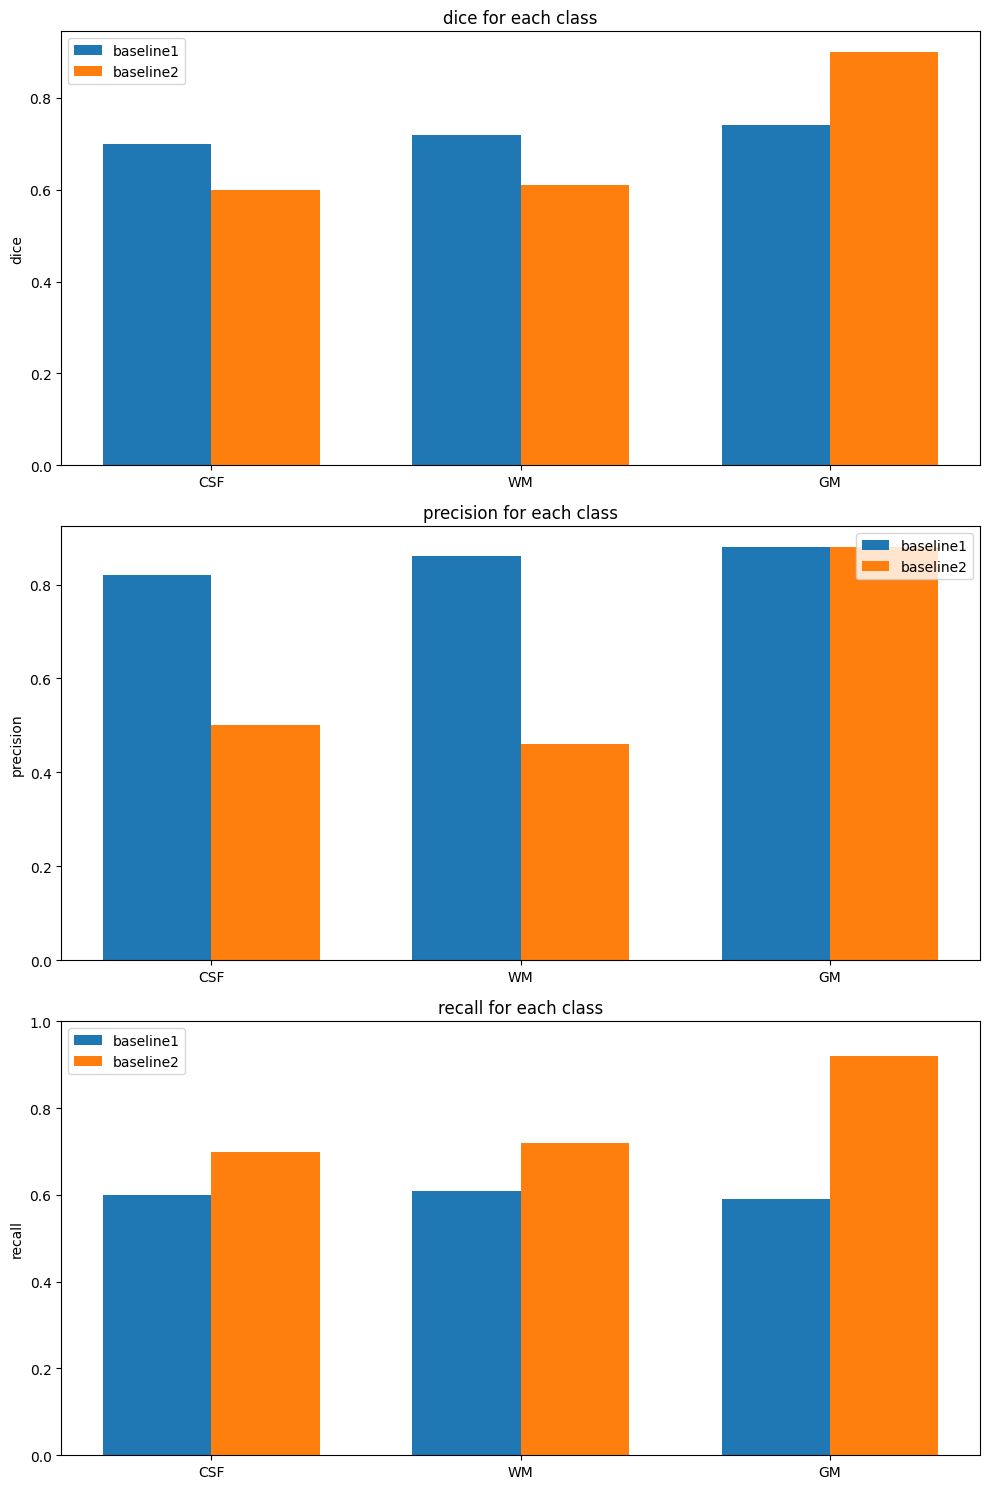

In [ ]:
"""TEST plot_results_summary"""
sample_results = {
    "baseline1": {
        "CSF": {"dice": "0.7", "precision": "0.82", "recall": "0.6"},
        "WM": {"dice": "0.72", "precision": "0.86", "recall": "0.61"},
        "GM": {"dice": "0.74", "precision": "0.88", "recall": "0.59"},
    },
    "baseline2": {
        "CSF": {"dice": "0.6", "precision": "0.5", "recall": "0.7"},
        "WM": {"dice": "0.61", "precision": "0.46", "recall": "0.72"},
        "GM": {"dice": "0.9", "precision": "0.88", "recall": "0.92"},
    },
}
plot_results_summary(sample_results)
# plot_results_summary(test_output)


In [ ]:
del test_pred

# Task 2: Unsupervised segmentation

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

In [ ]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()
# segmentations_val is now tensor
# convert to numpy
seg_ = seg_.cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning

Experimentation with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc...


In [ ]:
import sys
from sklearn.cluster import KMeans

testDataArray = []

for file_name in test_files:
    scan3d = load_nii(file_name)
    testDataArray.append(scan3d)

testDataArray = np.array(testDataArray)

In [ ]:

def kmeans_clustering(input_ndarray, num_clusters = 4, num_features = 1):
    """K means/ without any training

    Parameters
    ----------
    input_ndarray : ndarray
        any shape of the whole dataset
    num_clusters : int
        number of clusters

    Returns
    -------
    out : ndarray
        shape like input_ndarray

    """
    out = []

    # iterate over each scan separately because they don't all fit in RAM
    for scan in input_ndarray:

        # save input shape
        scan_shape = scan.shape

        # reshape to (num_datapoints, num_features)
        input_flattened = scan.reshape( scan.size // num_features , -1)

        kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
        kmeans.fit(input_flattened)

        centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        """ The lables returned by kmeans.fit correctly group the different
        tissue types but they assign a random class to them. The ground truth
        classes are ordered accendingly according to intensity. So the labels
        have to be permuted to also be ordered according to intensity.
        This permutating only works when clustering on the intensitiy. """

        # Takes the center values and pairs them with their index
        centerPairs = [ (centers[i],i) for i in range(len(centers)) ]
        centerPairs.sort()
        # The centers are ordered accendingly, the index paired with them shows where they where in the original center array.
        _, indicesChanged = zip(*centerPairs)
        # This generates the permuation array. The each index of the permutation array is mapped to the element saved at that index.
        permutation = np.zeros(len(indicesChanged))
        for i in range(len(indicesChanged)):
            permutation[indicesChanged[i]] = i

        # this permutes all labels accoring to the 'permutation' array
        labels_permuted = [permutation[i] for i in labels]
        labels_permuted = np.array(labels_permuted)
        labels_permuted = labels_permuted.reshape(scan_shape)

        out.append(labels_permuted)

    return torch.tensor(np.array(out), device = device)

pred_seg_1 = kmeans_clustering(testDataArray)


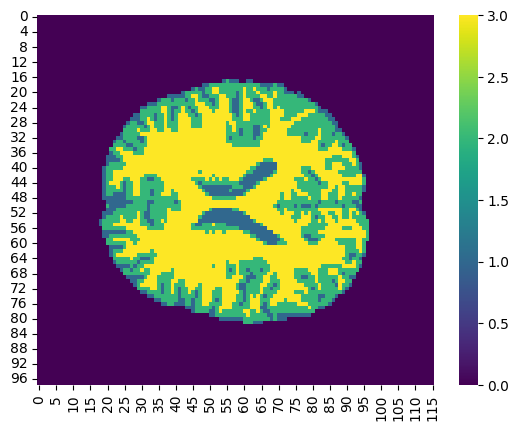

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns.heatmap(pred_seg_1.cpu().numpy()[0][:,:,47], cmap='viridis')
plt.show()
# ----------------------------------- END -------------------------------------

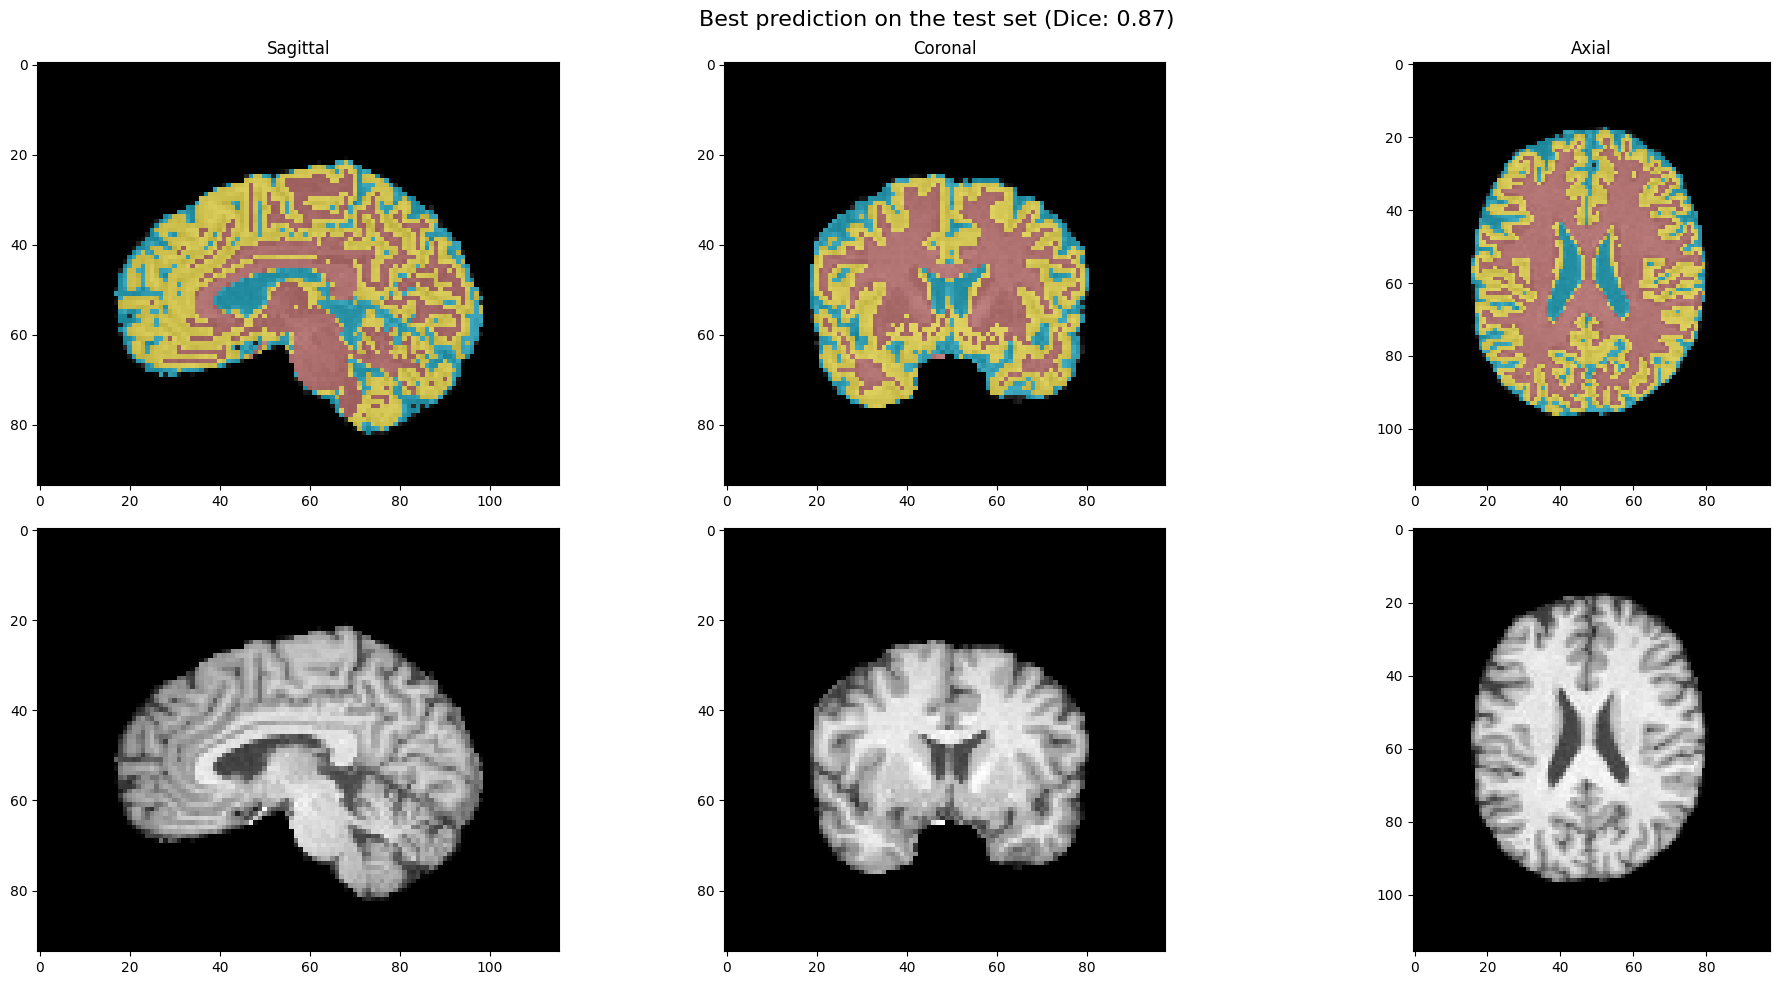

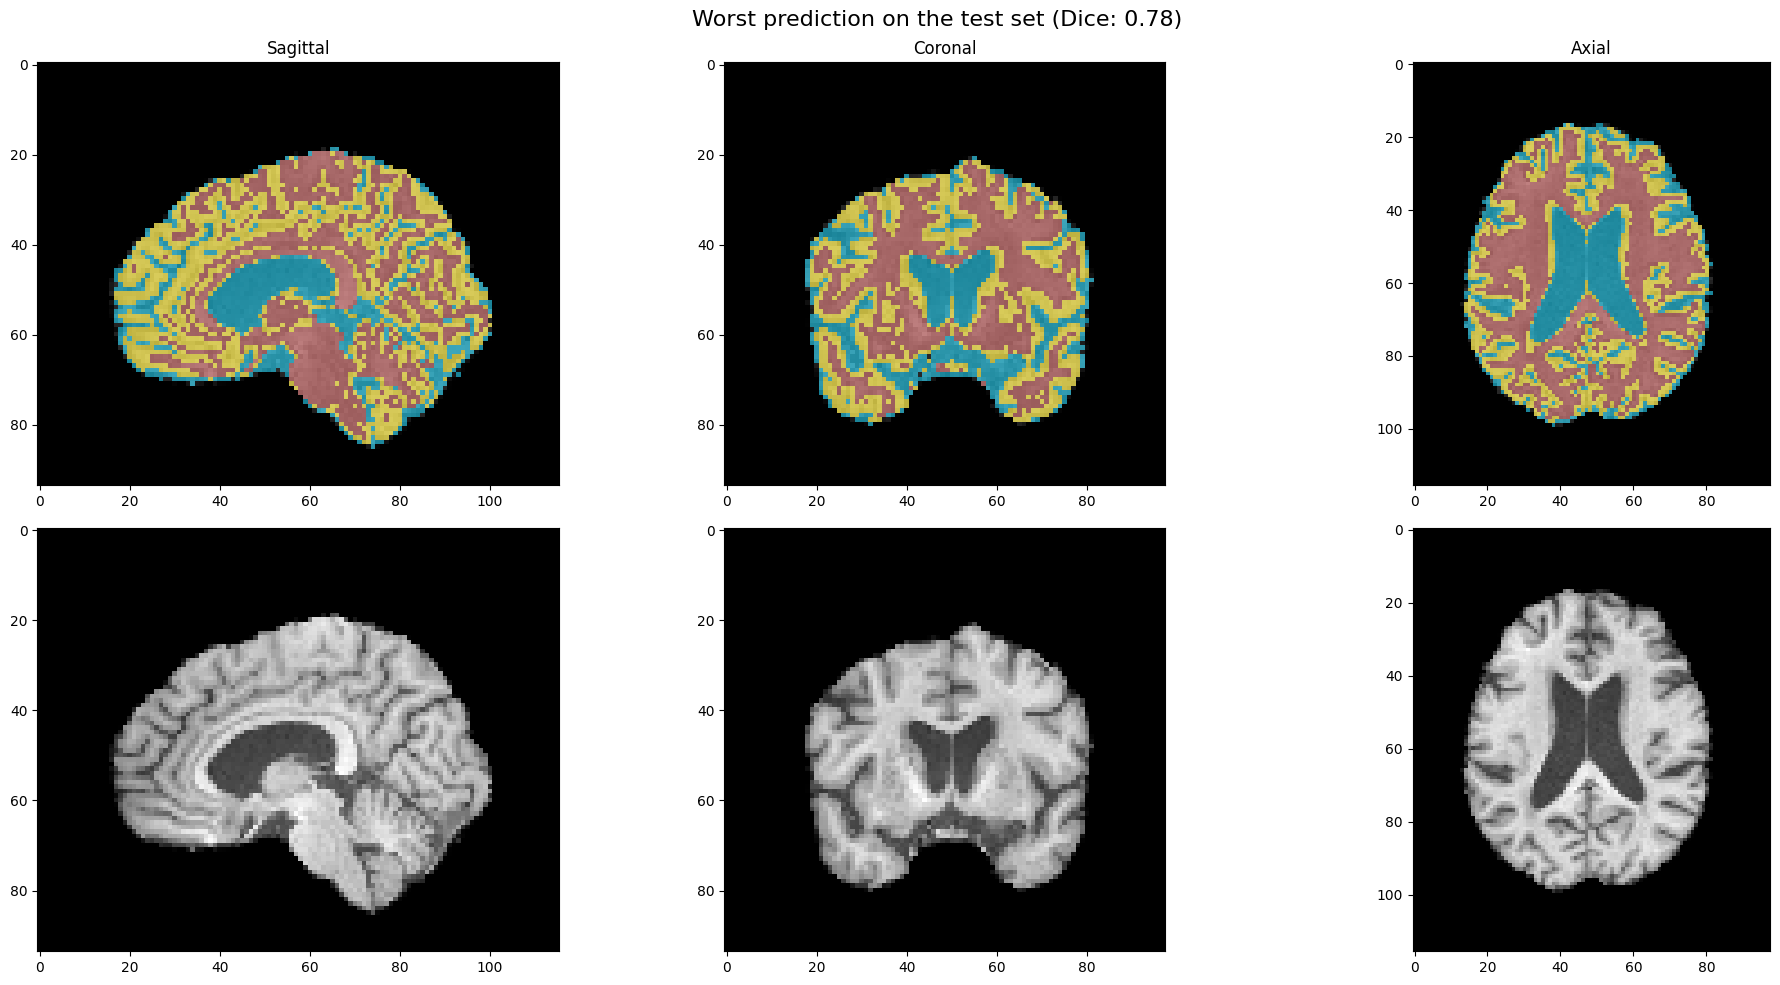

In [ ]:
# Visualize the best and worst predictions on the test set
pred_seg_1_= pred_seg_1.cpu().numpy()
visualize_best_and_worst_samples(pred_seg_1)

#### QUESTION Q2b.
Implement a second unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2.

In [ ]:
from sklearn.mixture import GaussianMixture
def gmm_clustering(input_ndarray2):
    """GMM

    Parameters
    ----------
    input_ndarray2 : ndarray
        any shape of the whole dataset

    Returns
    -------
    out2 : ndarray
        shape like input_ndarray

    """
    out2 = []

    for scan2 in input_ndarray2:

      scan_shape2 = scan2.shape

      input_flattened2 = scan2.reshape( scan2.size, -1)

      gmm = GaussianMixture(n_components=4)
      gmm.fit(input_flattened2)
      means = gmm.means_

      labels2 = np.argmax(gmm.predict_proba(input_flattened2), axis=1)

      meanPairs = [ (means[i],i) for i in range(len(means)) ]
      meanPairs.sort()
      _, indicesChanged2 = zip(*meanPairs)
      permutation2 = np.zeros(len(indicesChanged2))
      for i in range(len(indicesChanged2)):
          permutation2[indicesChanged2[i]] = i

      labels_permuted2 = [permutation2[i] for i in labels2]
      labels_permuted2 = np.array(labels_permuted2)
      labels_permuted2 = labels_permuted2.reshape(scan_shape2)
      out2.append(labels_permuted2)

    return torch.tensor(np.array(out2), device = device)

pred_seg_2 = gmm_clustering(testDataArray)


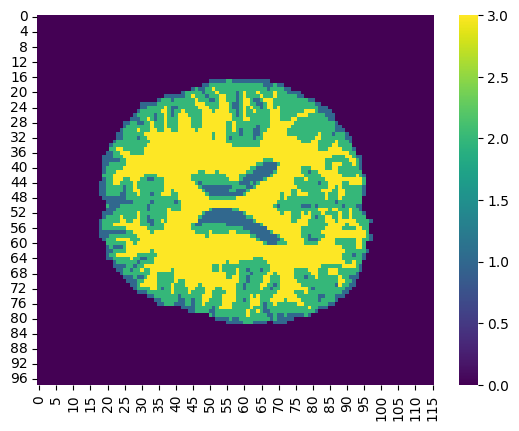

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set
sns.heatmap(pred_seg_2.cpu().numpy()[0][:,:,47], cmap='viridis')
plt.show()


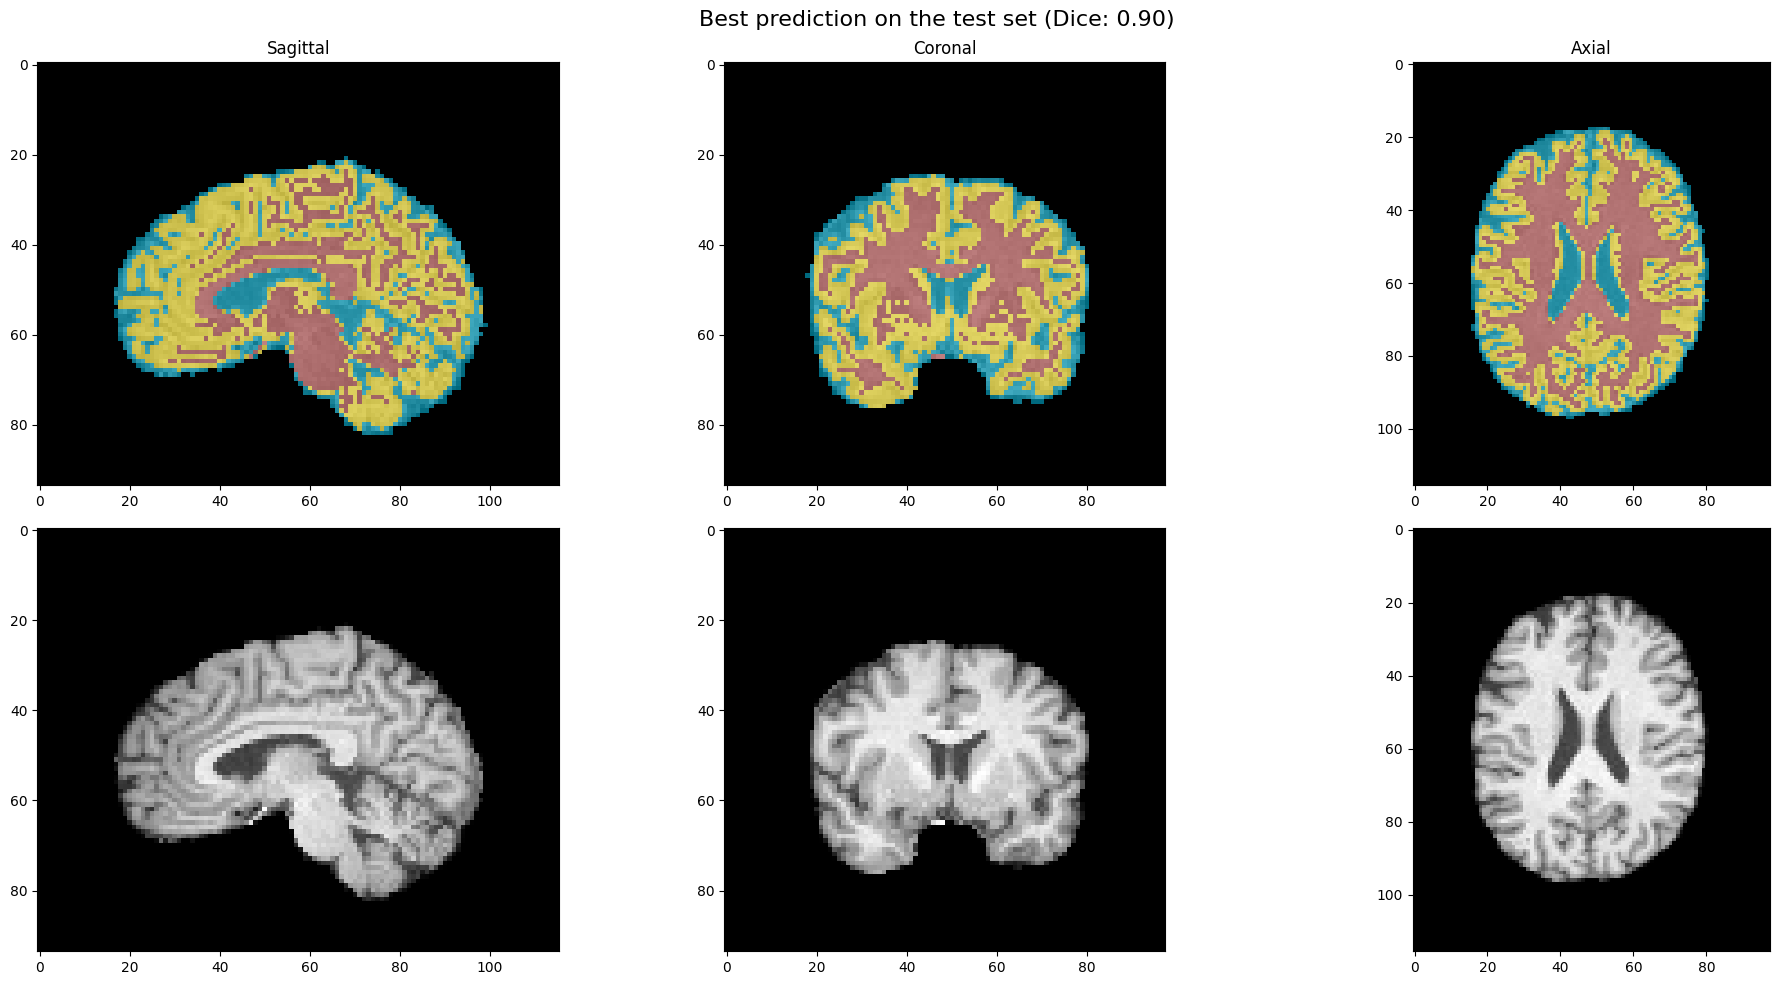

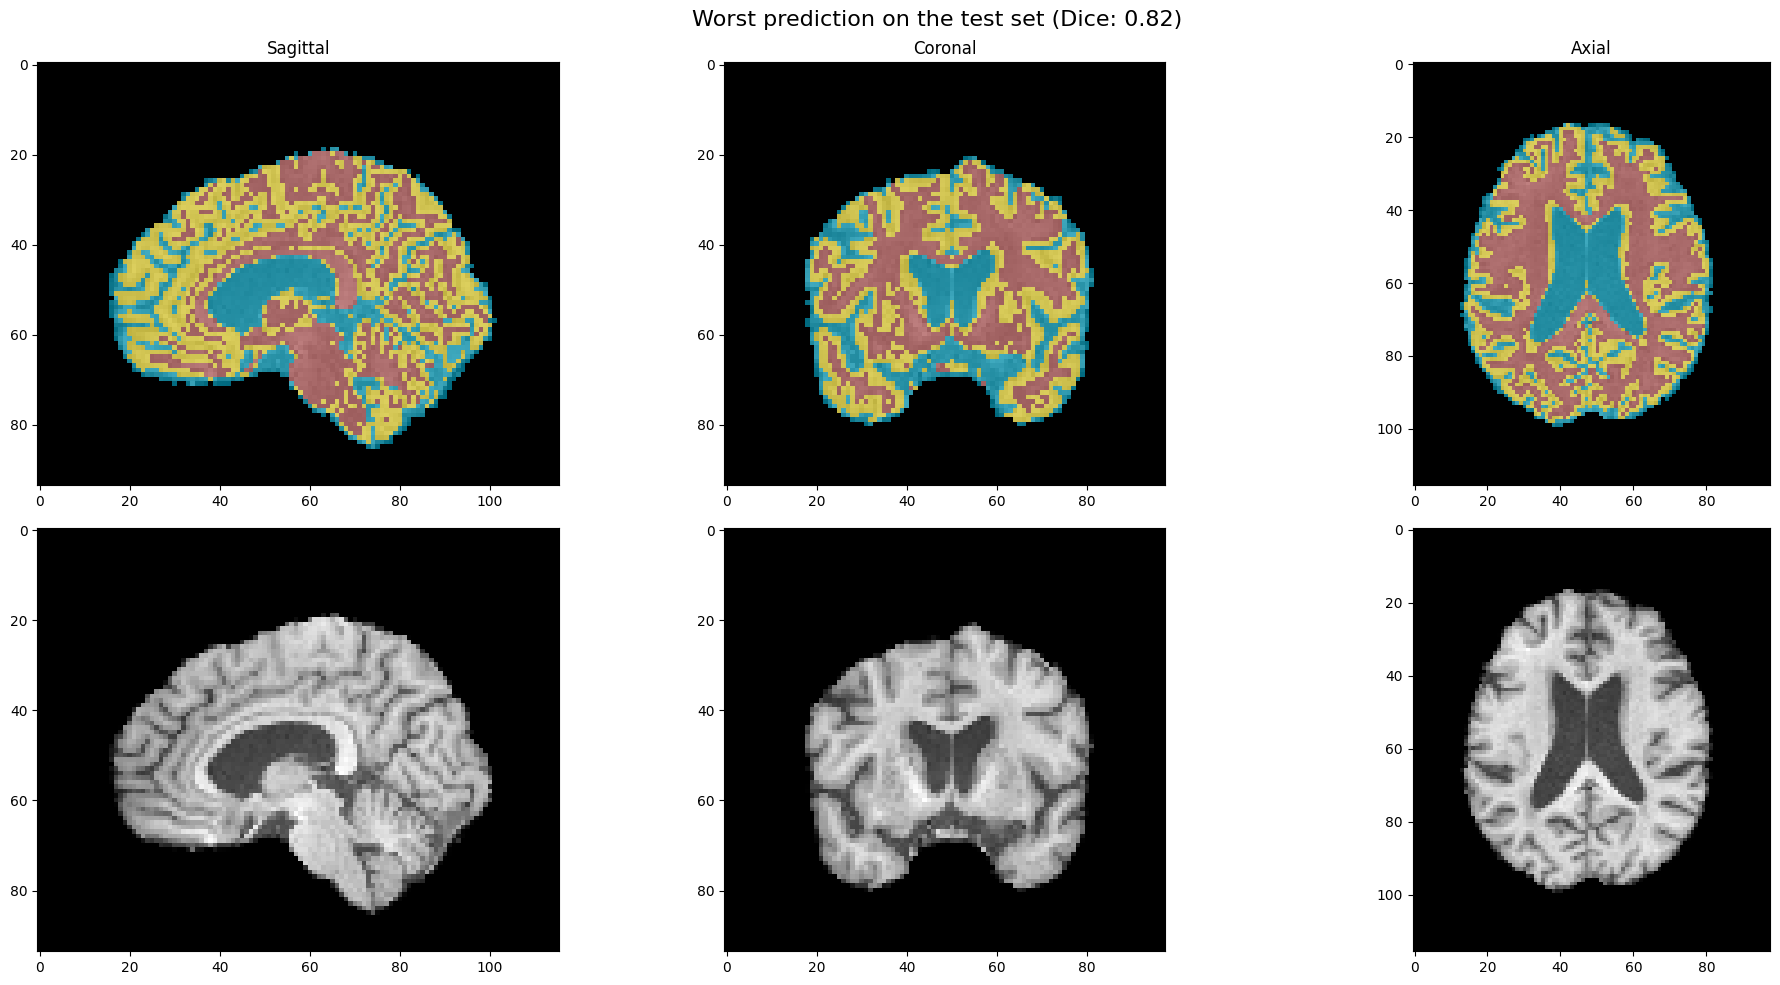

In [ ]:
visualize_best_and_worst_samples(pred_seg_2)

In [ ]:
del testDataArray

# Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

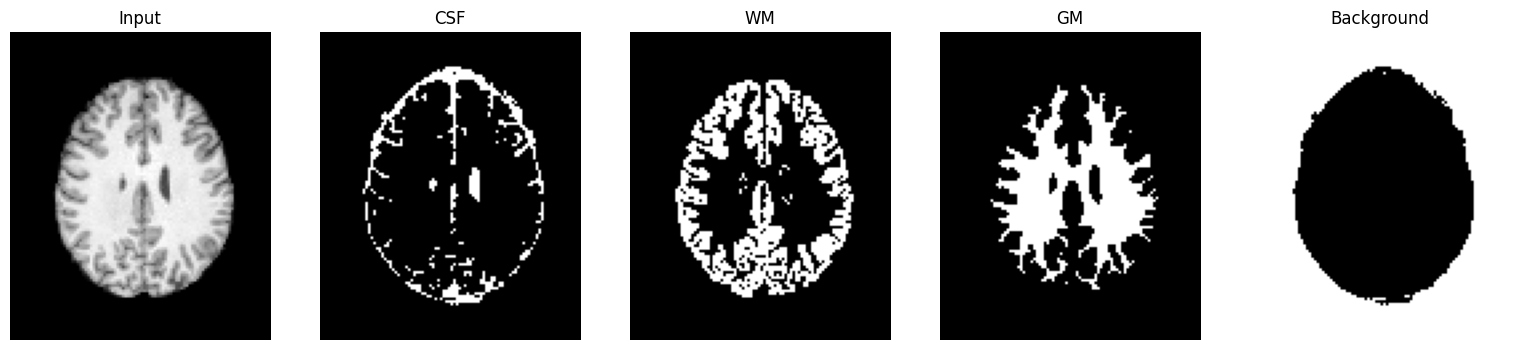

In [ ]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val.cpu()[0]==1] = 1
wm[segmentations_val.cpu()[0]==2] = 1
gm[segmentations_val.cpu()[0]==3] = 1
background[segmentations_val.cpu()[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,50])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation

Training a U-Net for segmentation (use the train, val, and test splits defined above).

The hyperparameters are adapted to the capacity of a free acount on google colab(16G T4 GPU)
The model is trained from scratch without pretraining

In [ ]:
#input size is 98 116 94

import torch.nn as nn
class UNet_3L_32(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # padding: 98,116,94 -> 128,128,128
        self.preprocessiong_pad = nn.ReplicationPad3d((17,17,6,6,15,15))

        # Encoder
        self.e11 = nn.Conv3d(1, 32, kernel_size=3, padding=1) #  128
        self.e12 = nn.Conv3d(32, 32, kernel_size=3, padding=1) #
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2) # 64

        #
        self.e21 = nn.Conv3d(32, 64, kernel_size=3, padding=1) #
        self.e22 = nn.Conv3d(64, 64, kernel_size=3, padding=1) #
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2) # output: 32

        #
        self.e31 = nn.Conv3d(64, 128, kernel_size=3, padding=1) #
        self.e32 = nn.Conv3d(128, 128, kernel_size=3, padding=1) #
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2) # output: 16

        #
        self.e41 = nn.Conv3d(128, 256, kernel_size=3, padding=1) #

        # bottleneck block
        self.e42_1 = nn.Conv3d(256, 64, kernel_size=1)
        self.e42 = nn.Conv3d(64, 64, kernel_size=3, padding=1) #
        self.e42_2 = nn.Conv3d(64, 256, kernel_size=1)


        # Decoder
        self.upconv1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.d11 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.d12 = nn.Conv3d(128, 128, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.d21 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.d22 = nn.Conv3d(64, 64, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.d31 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.d32 = nn.Conv3d(32, 32, kernel_size=3, padding=1)


        # Output layer
        self.outconv = nn.Conv3d(32, n_class, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        relu = nn.ReLU()

        # pad input to 128,128,128 (so that the dimension reduction can be mitigated)
        xp = self.preprocessiong_pad(x)

        # Encoder
        xe11 = relu(self.e11(xp))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        # bottleneck block
        xe42_1 = relu(self.e42_1(xe41))
        xe42_c = relu(self.e42(xe42_1))
        xe42_2 = relu(self.e42_2(xe42_c))
        xe42 = xe42_2 + xe41

        # Decoder
        xu1 = self.upconv1(xe42)
        xu11 = torch.cat([xu1, xe32], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe22], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe12], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))


        # Output layer
        out = self.outconv(xd32)
        # out = self.softmax(out_n)

        # crop the original size  98 116 94
        15,15,6,6,17,17
        out = out[:,:,15:-15,6:-6,17:-17]

        return out






In [ ]:
# Load model
model = torch.load(root_dir.joinpath("unet_3d_3L_32_model_35epochs.pt"))

In [ ]:
from torchsummary import summary

model =UNet_3L_32(n_class = 4)
model.to(device)
SAMPLE_SIZE = (1,98,116,94)
summary(model, SAMPLE_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
  ReplicationPad3d-1     [-1, 1, 128, 128, 128]               0
            Conv3d-2    [-1, 32, 128, 128, 128]             896
            Conv3d-3    [-1, 32, 128, 128, 128]          27,680
         MaxPool3d-4       [-1, 32, 64, 64, 64]               0
            Conv3d-5       [-1, 64, 64, 64, 64]          55,360
            Conv3d-6       [-1, 64, 64, 64, 64]         110,656
         MaxPool3d-7       [-1, 64, 32, 32, 32]               0
            Conv3d-8      [-1, 128, 32, 32, 32]         221,312
            Conv3d-9      [-1, 128, 32, 32, 32]         442,496
        MaxPool3d-10      [-1, 128, 16, 16, 16]               0
           Conv3d-11      [-1, 256, 16, 16, 16]         884,992
           Conv3d-12       [-1, 64, 16, 16, 16]          16,448
           Conv3d-13       [-1, 64, 16, 16, 16]         110,656
           Conv3d-14      [-1, 256, 16,

In [ ]:
def prepare_seg(segmentation):
  """  turn segmentations (B,W,D,H) with class numbers for each pxiel
  to gt (B,num_class,W,D,H)"""
  res = (segmentation==0).unsqueeze(1)
  res = torch.cat((res,(segmentation==1).unsqueeze(1)), dim = 1)
  res = torch.cat((res,(segmentation==2).unsqueeze(1)), dim = 1)
  res = torch.cat((res,(segmentation==3).unsqueeze(1)), dim = 1)
  return res

gt_train = prepare_seg(segmentations_train)
gt_val = prepare_seg(segmentations_val)
gt_test = prepare_seg(segmentations_test)

In [ ]:
print(gt_train.shape, gt_val.shape, gt_test.shape)
del segmentations_train, segmentations_val,
torch.cuda.empty_cache()

torch.Size([522, 4, 98, 116, 94]) torch.Size([65, 4, 98, 116, 94]) torch.Size([65, 4, 98, 116, 94])


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_images = []
for file in tqdm(train_files):
  train_images.append(load_nii(file))

val_images = []
for file in tqdm(val_files):
    val_images.append(load_nii(file))

100%|██████████| 65/65 [00:01<00:00, 44.73it/s]


In [ ]:
train_images = torch.Tensor(np.array(train_images)).unsqueeze(1)
val_images = torch.Tensor(np.array(val_images)).unsqueeze(1)

print(train_images.shape)
print(val_images.shape)

torch.Size([522, 1, 98, 116, 94])
torch.Size([65, 1, 98, 116, 94])


In [ ]:
BATCH_SIZE = 2
train_dataset = TensorDataset(train_images, gt_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(val_images, gt_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
del train_images, val_images
del gt_train, gt_val
torch.cuda.empty_cache()

In [ ]:
# optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, # <--- Feel free to play around with the lr parameter.
                             weight_decay=5e-2, amsgrad=True)
loss_f = torch.nn.BCEWithLogitsLoss()


def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    device = next(model.parameters()).device
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair

        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.float().to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_f(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % len(train_loader) == len(train_loader)-1:
            last_loss = running_loss / len(train_loader) # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/trainer_{}'.format(timestamp))
epoch_number = 0

# minimum Epochs >= 20
# recommended Epochs >= 50
EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs = vinputs.to(device)
          vlabels = vlabels.float().to(device)
          voutputs = model(vinputs)
          vloss = loss_f(voutputs, vlabels)
          running_vloss += vloss

    avg_vloss = running_vloss / len(val_loader)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    #log the running loss averaged per batch
    #for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # #track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    #     best_vloss = avg_vloss
    #     model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(model.state_dict(), model_path)

    torch.save(model,root_dir.joinpath("unet_3d_3L_32_model_wholemodel_final8_"+str(epoch_number)+".pt"))

    epoch_number += 1


EPOCH 1:
  batch 261 loss: 0.06348586467833355
LOSS train 0.06348586467833355 valid 0.06429183483123779
EPOCH 2:
  batch 261 loss: 0.06324967559270019
LOSS train 0.06324967559270019 valid 0.06737110763788223
EPOCH 3:
  batch 261 loss: 0.06336062644176556
LOSS train 0.06336062644176556 valid 0.06647386401891708
EPOCH 4:
  batch 261 loss: 0.06329135812276625
LOSS train 0.06329135812276625 valid 0.06679744273424149
EPOCH 5:
  batch 261 loss: 0.06350231615976355
LOSS train 0.06350231615976355 valid 0.06524220108985901
EPOCH 6:
  batch 261 loss: 0.06326996899027934
LOSS train 0.06326996899027934 valid 0.06693390756845474
EPOCH 7:


KeyboardInterrupt: ignored

torch.Size([1, 1, 98, 116, 94])


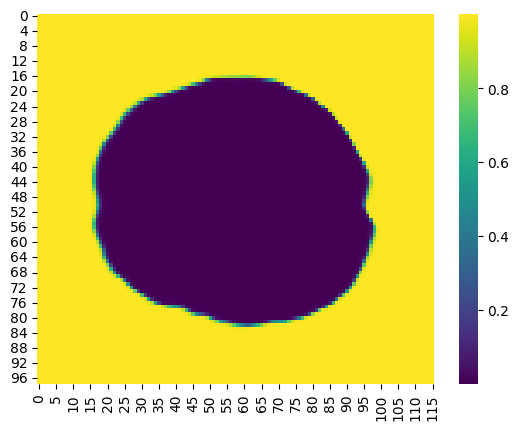

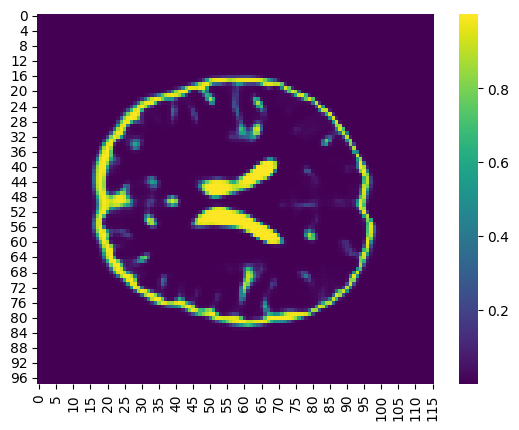

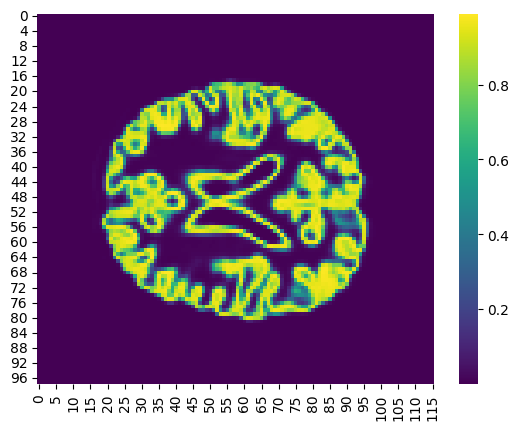

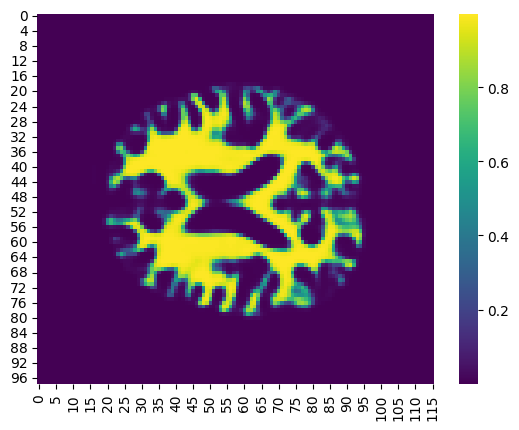

In [ ]:
model.eval()

test_scan_1 = torch.tensor(load_nii(test_files[0]),device = device).unsqueeze(0).unsqueeze(0)
print(test_scan_1.shape)
with torch.no_grad():
  outputs = model(test_scan_1)
opsoftmax = nn.Softmax(dim=1)
outputs = opsoftmax(outputs)
sns.heatmap(outputs.detach().cpu().numpy()[0][0][:,:,47], cmap='viridis')
plt.show()
sns.heatmap(outputs.detach().cpu().numpy()[0][1][:,:,47], cmap='viridis')
plt.show()
sns.heatmap(outputs.detach().cpu().numpy()[0][2][:,:,47], cmap='viridis')
plt.show()
sns.heatmap(outputs.detach().cpu().numpy()[0][3][:,:,47], cmap='viridis')
plt.show()

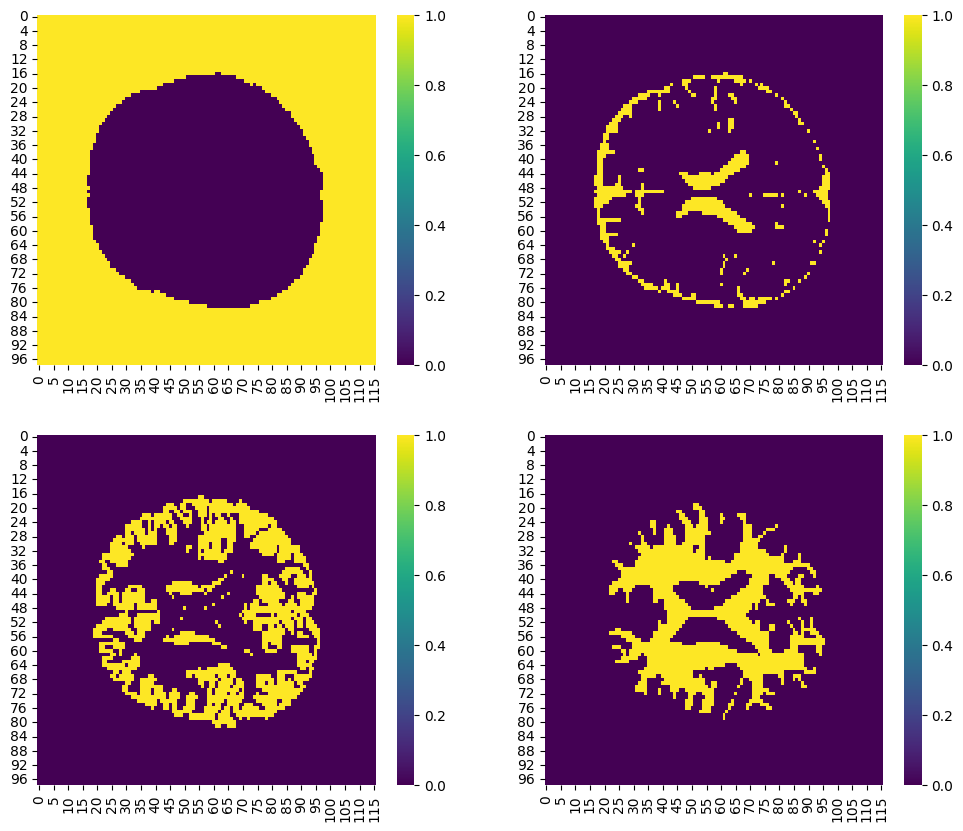

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plt_seg_1 = sns.heatmap(gt_test.cpu().numpy()[0][0][:,:,47], cmap='viridis', ax=axs[0, 0])
plt_seg_2 = sns.heatmap(gt_test.cpu().numpy()[0][1][:,:,47], cmap='viridis', ax=axs[0, 1])
plt_seg_3 = sns.heatmap(gt_test.cpu().numpy()[0][2][:,:,47], cmap='viridis',  ax=axs[1, 0])
plt_gt = sns.heatmap(gt_test.cpu().numpy()[0][3][:,:,47], cmap='viridis', ax=axs[1, 1])
plt.show()



### Evaluate the Dice scores (separately for every tissue type) for the whole test set.

In [ ]:
test_images = []
for file in tqdm(test_files):
    test_images.append(load_nii(file))

100%|██████████| 65/65 [00:01<00:00, 40.43it/s]


In [ ]:
test_images_tensor = torch.tensor(np.array(test_images),device = device).unsqueeze(1)
print(test_images_tensor.shape)

torch.Size([65, 1, 98, 116, 94])


In [ ]:
count = 0
output_test = []
model.to(device)
with torch.no_grad():
  for image in tqdm(test_images_tensor):
    pred = model(image.unsqueeze(0))
    output_test.append(pred.squeeze().to("cpu").numpy())


100%|██████████| 65/65 [00:18<00:00,  3.52it/s]


In [ ]:
pred_seg_3 = np.array(output_test).squeeze()
del output_test
print(pred_seg_3.shape)


(65, 4, 98, 116, 94)


In [ ]:
pred_seg_3 = torch.tensor(pred_seg_3, device = device)
pred_seg_3 = torch.argmax(pred_seg_3, dim=1)
print(pred_seg_3.shape)
print(segmentations_test.shape)

torch.Size([65, 98, 116, 94])
torch.Size([65, 98, 116, 94])


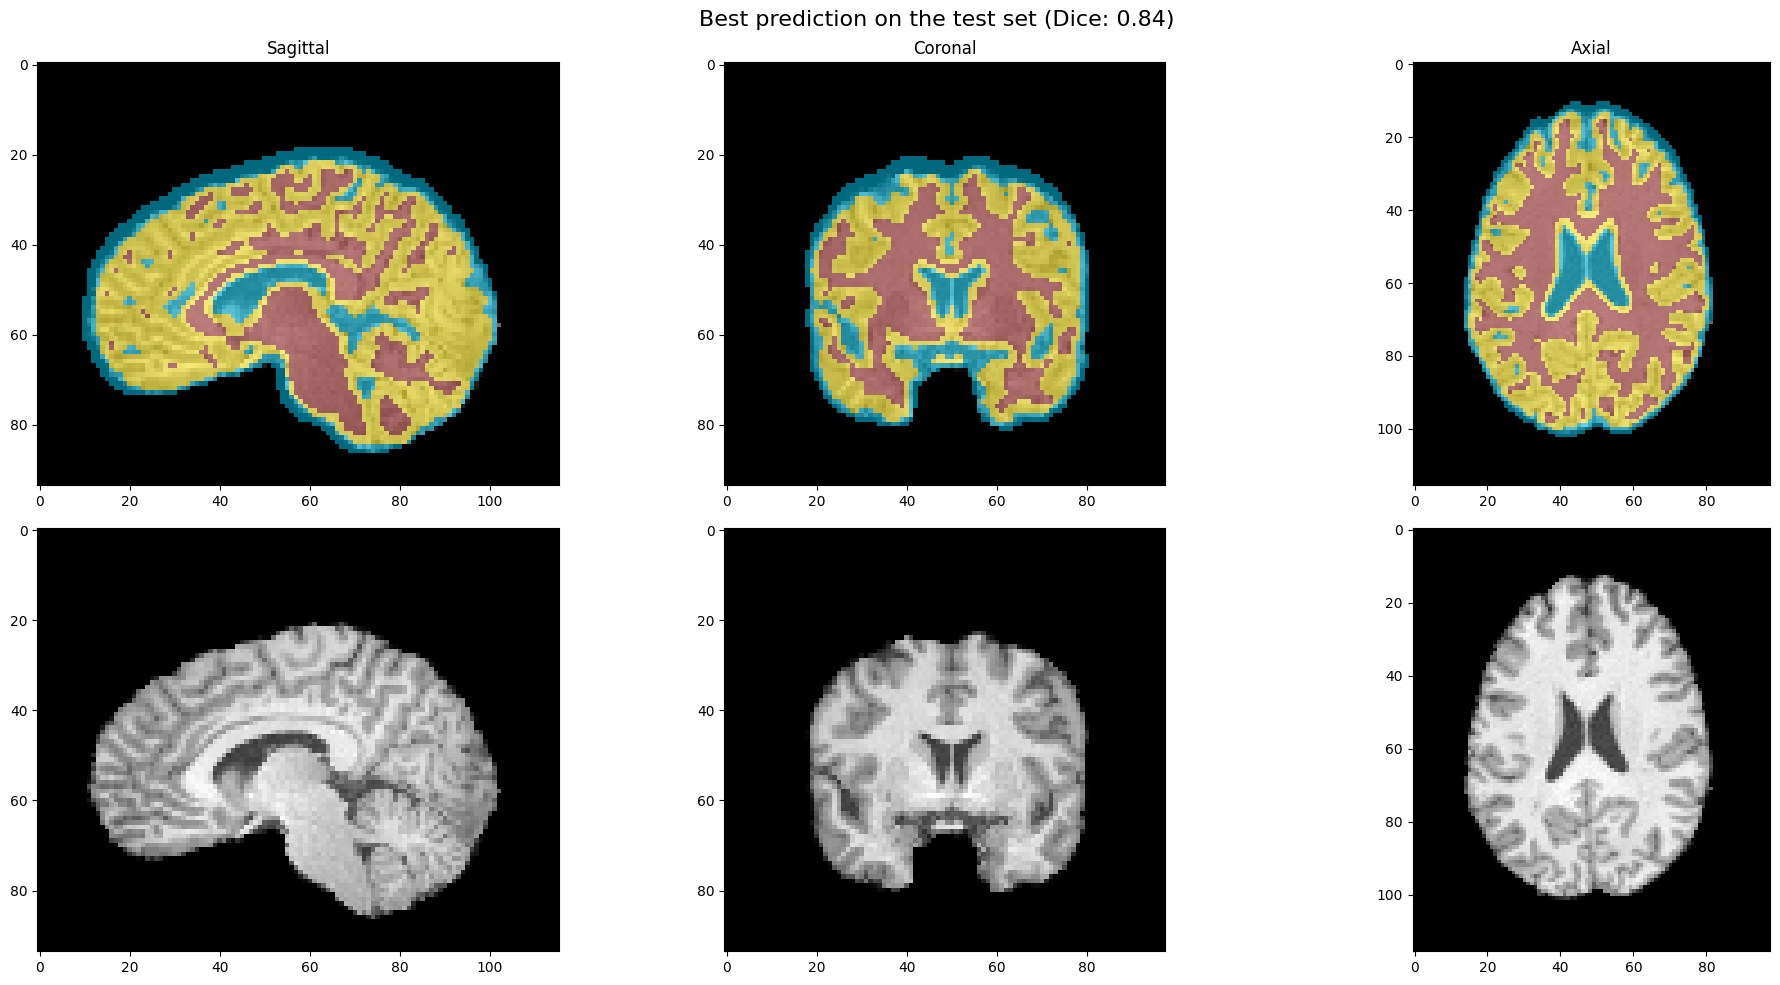

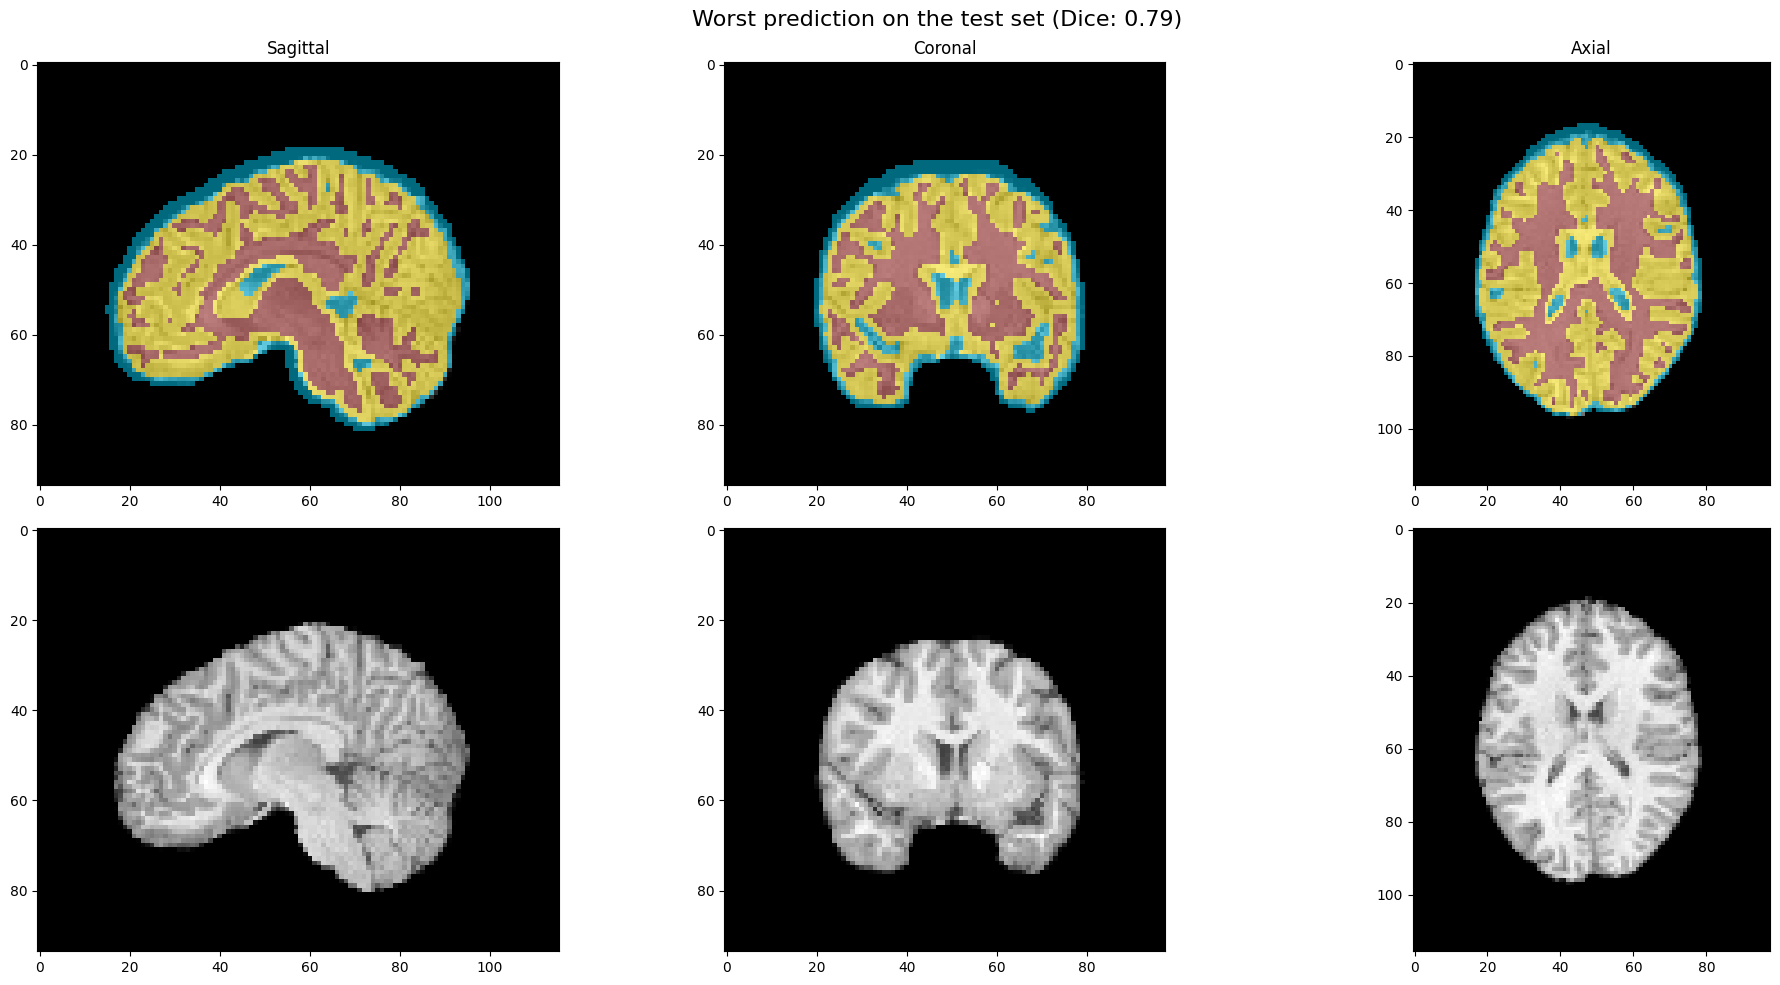

In [ ]:
# Run this block after implementing Q3.
visualize_best_and_worst_samples(pred_seg_3)

### Summarize the results of all of the segmentation methods implemented.

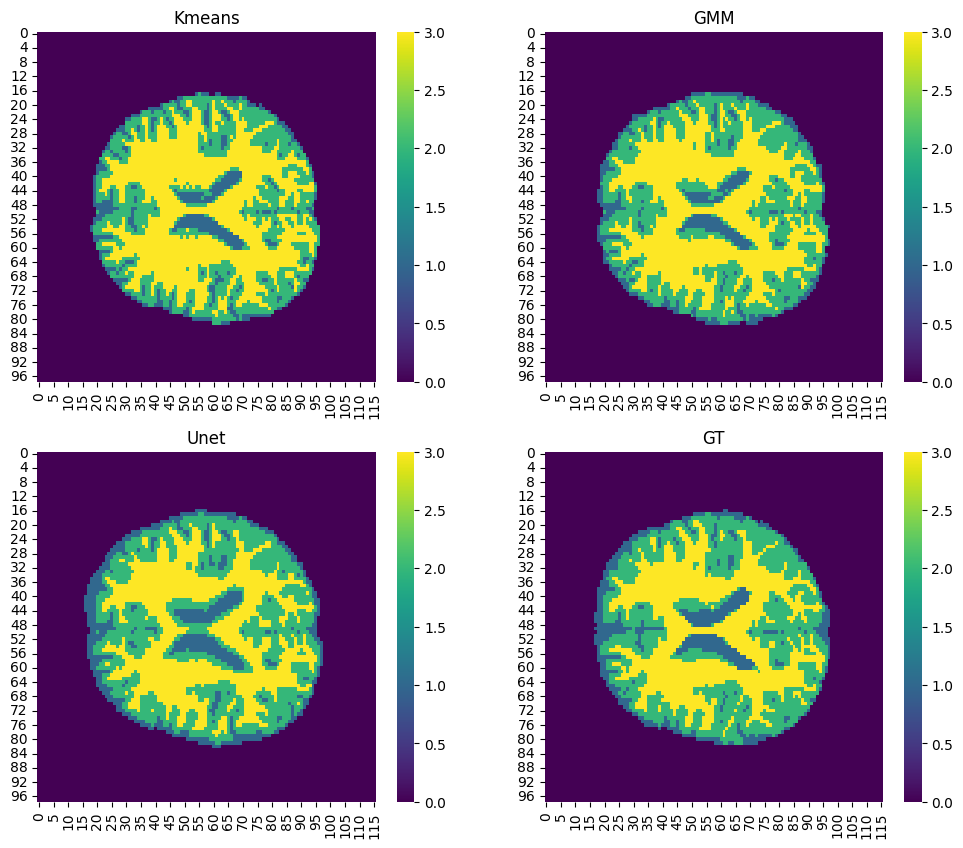

In [ ]:
# Visualize individual segmentation channels for axial slice 47 of all three approaches and the ground truth in a similar style as above
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plt_seg_1 = sns.heatmap(pred_seg_1[0][:,:,47].cpu().numpy(), cmap='viridis', ax=axs[0, 0])
axs[0, 0].set_title('Kmeans')
plt_seg_2 = sns.heatmap(pred_seg_2[0][:,:,47].cpu().numpy(), cmap='viridis', ax=axs[0, 1])
axs[0, 1].set_title('GMM')
plt_seg_3 = sns.heatmap(pred_seg_3[0][:,:,47].cpu().numpy(), cmap='viridis',  ax=axs[1, 0])
axs[1, 0].set_title('Unet')
plt_gt = sns.heatmap(segmentations_test[0][:,:,47].cpu().numpy(), cmap='viridis', ax=axs[1, 1])
axs[1, 1].set_title('GT')
plt.show()

# ----------------------------------- END -------------------------------------

{'model0': {'CSF': {'dice': '0.6522508859634399', 'precision': '0.9293847680091858', 'recall': '0.5053873062133789'}, 'GM': {'dice': '0.8198383450508118', 'precision': '0.8998583555221558', 'recall': '0.7534955143928528'}, 'WM': {'dice': '0.850919783115387', 'precision': '0.747637927532196', 'recall': '0.9883580207824707'}}, 'model1': {'CSF': {'dice': '0.6904905438423157', 'precision': '0.8530794978141785', 'recall': '0.5836349129676819'}, 'GM': {'dice': '0.8684744238853455', 'precision': '0.902431309223175', 'recall': '0.8377925157546997'}, 'WM': {'dice': '0.8934239149093628', 'precision': '0.8257800936698914', 'recall': '0.9748709797859192'}}, 'model2': {'CSF': {'dice': '0.7869412899017334', 'precision': '0.8214440941810608', 'recall': '0.7620244026184082'}, 'GM': {'dice': '0.8598901629447937', 'precision': '0.8685740828514099', 'recall': '0.852627694606781'}, 'WM': {'dice': '0.871881365776062', 'precision': '0.8454256057739258', 'recall': '0.9016790390014648'}}}


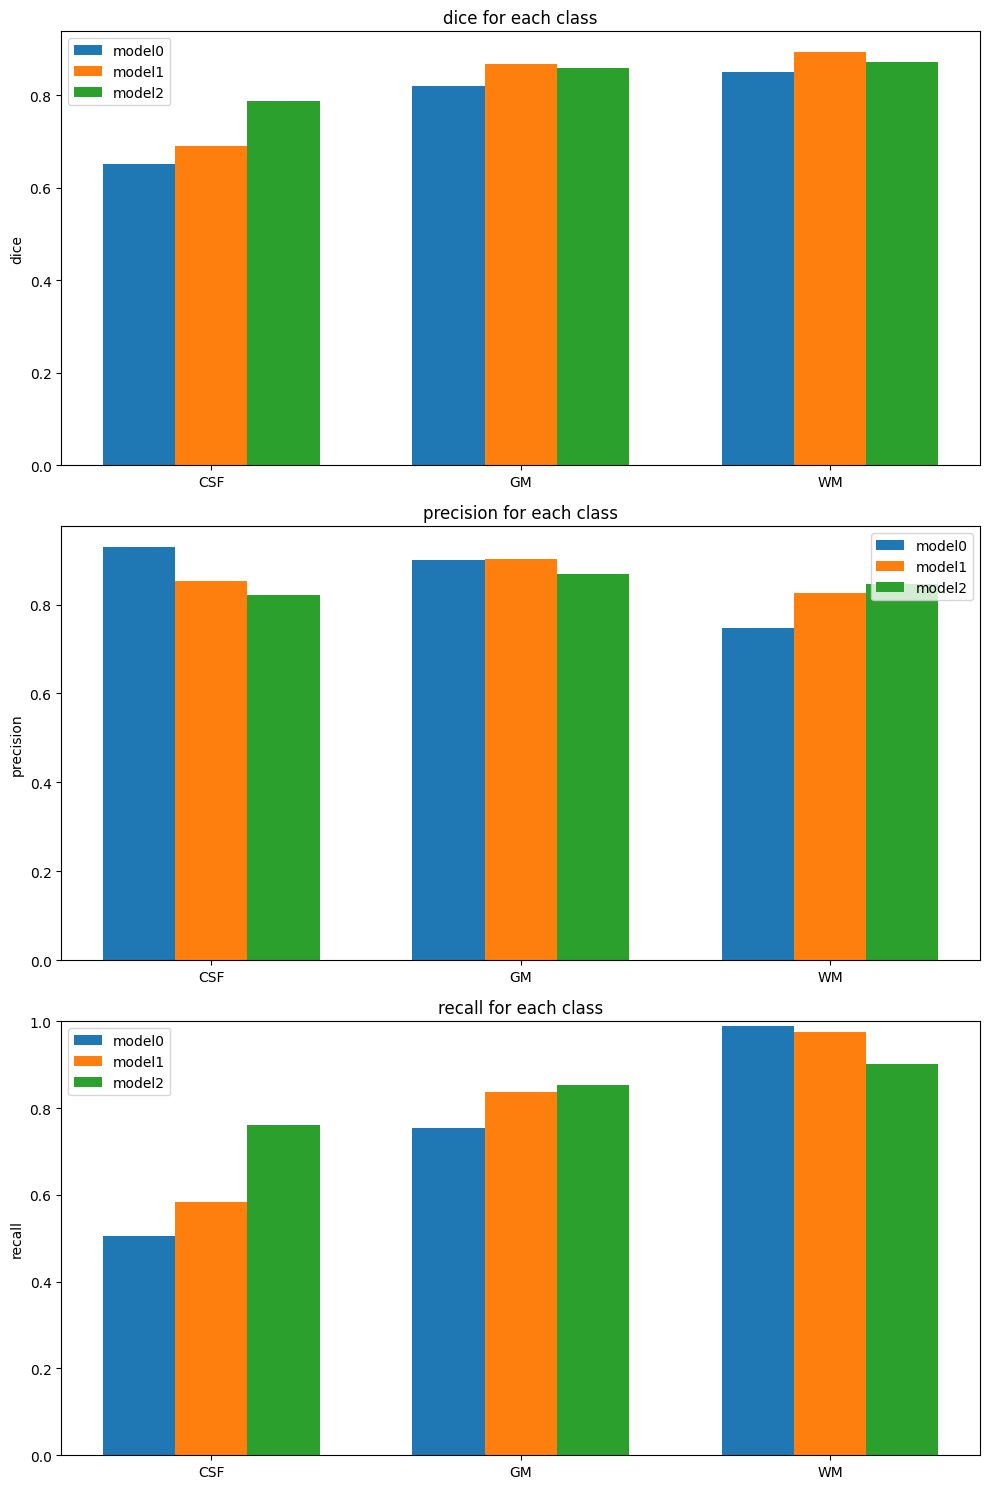

In [ ]:
# Run this block after implementing Q1-3.
# results_dictionary = {
#     'unsupervised1': get_results_dictionary(pred_seg_1),
#     'unsupervised2': get_results_dictionary(pred_seg_2),
#     'u-net': get_results_dictionary(pred_seg_3),
# }
models_outputs = torch.stack((pred_seg_1, pred_seg_2, pred_seg_3))
results_dictionary = get_results_dictionary(models_outputs)
print(results_dictionary)
plot_results_summary(results_dictionary)